# Q3: What price should I set my property at in order to be similar to the others? 

This nb builds a model based on the **listings_clean.csv** dataframe created using **listings.csv** built within the notebook called **0_listing_data_prep**. A Ridge regression model with 14 features is built to predict price and a property is chosen at random to present on the blog.

The notebook also contains initial analysis and a few challenger models.

Future work:

* Recode no_of_reviews to capture a linear relationship
* Come back to check how review score might influence price.
* Add in CIs
* Consider adding in some Interaction terms like bathrooms x bedrooms
* Impute Missing values instead of dropping them
* Consider dropping Outliers to see what impact this has
* More Hyperparamter tuning like the alpha in the ridge regression
* Validate on segments e.g. Private vs Shared
* Try cross validation
* Try out more complex models like XGboost - more difficult to present as calculator on the blog though
* Can we do something with latitude and longitude like distance from point X

## Set-up and read in data

In [1]:
## For nicer colours
!pip install colorcet

import sys
import colorcet as cc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# modelling
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# set-up colours
palette = sns.color_palette(cc.glasbey, n_colors=17)
# view colours
# sns.palplot(palette)
sns.set_palette(palette)

# print versions
print("Current version of Python is ", sys.version)
print("Current version of numpy is ",np.__version__)
print("Current version of Pandas is ",pd.__version__)
print("Current version of sklearn is ",sklearn.__version__)
print("Current version of colorcet is ",cc.__version__)
print("Current version of matplotlib is ",matplotlib.__version__)
print("Current version of seaborn is ",sns.__version__)

Current version of Python is  3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
Current version of numpy is  1.19.5
Current version of Pandas is  1.1.5
Current version of sklearn is  0.24.1
Current version of colorcet is  3.0.0
Current version of matplotlib is  3.3.4
Current version of seaborn is  0.11.1


In [2]:
# read in data
df_listing_clean = pd.read_csv('./listings_clean.csv')

## Define user functions

In [3]:
def print_eval_reg(model):
    """
    
    Prints R-squared and MSE for the train and the test data and graphs of Actuals vs Predicted.
        Input: 
            The model being evaluated
    
    """
    
    #Predict and score the model
    y_test_preds = model.predict(X_all_test) 
    y_train_preds = model.predict(X_all_train) 

    #Rsquared and y_test
    rsquared_scoretest = r2_score(y_test, y_test_preds)
    rsquared_scoretrain = r2_score(y_train, y_train_preds)
    length_y_test = len(y_test)
    length_y_train = len(y_train)

    #  MSE
    mse_calctest = np.sqrt(mean_squared_error(y_test,y_test_preds))
    mse_calctrain = np.sqrt(mean_squared_error(y_train,y_train_preds))

    print('Train')
    print("The MSE for your model was {} on {} values.".format(mse_calctrain, length_y_train))
    print("The r-squared score for your model was {} on {} values.".format(rsquared_scoretrain, length_y_train))
    print('Test')
    print("The MSE for your model was {} on {} values.".format(mse_calctest, length_y_test))
    print("The r-squared score for your model was {} on {} values.".format(rsquared_scoretest, length_y_test))

    plt.subplot(1, 2, 1)
    plt.title("Train data")
    plt.scatter(y_train_preds, y_train);
    plt.xlabel('Predicted');
    plt.ylabel('Actuals');
    
    plt.subplot(1, 2, 2)
    plt.title("Test data")
    plt.scatter(y_test_preds, y_test);
    plt.xlabel('Predicted');
    plt.ylabel('Actuals');

## Drop additional columns

In [4]:
# Remove these as they are usually derivations of price which we are trying to predict 
df_listing_clean = df_listing_clean.drop(['security_deposit', 'cleaning_fee', 'extra_people'
                                         # latitude and longitude were coming into the model but aren't intuitive. 
                                          ## Distance from center or a particular point in map would be better 
                                           , 'latitude', 'longitude'
                                         ], axis = 1)

## Create dummy variables
*Good candidates for these were identified at the data prep stage but not done there in case these columns were required for question 2.*

In [5]:
# Missing values are coded as 0 by default but I'll set-up a separate flag to maintain this info

get_dummy_cols = [
'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 
'property_type_new', 'room_type', 'bed_type_new', 
'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification',
]


for col in get_dummy_cols:
    df_listing_clean = pd.concat([df_listing_clean.drop(col, axis=1), pd.get_dummies(df_listing_clean[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)

# Doing neighbourhood separately so that I can keep the original column
df_listing_clean = pd.concat([df_listing_clean, pd.get_dummies(df_listing_clean['neighbourhood_group_cleansed'], prefix='neighbourhood_group_cleansed', prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)

df_listing_clean.head()

,last_scraped,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,price_new,host_response_rate_new,host_acceptance_rate_new,days_since_first_review,days_since_last_review,days_since_host_since,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_t,host_identity_verified_nan,is_location_exact_t,is_location_exact_nan,property_type_new_House,property_type_new_Other,property_type_new_nan,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_new_Real Bed,bed_type_new_nan,instant_bookable_t,instant_bookable_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_t,require_guest_phone_verification_nan,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,neighbourhood_group_cleansed_nan
0,2016-01-04,3.0,3.0,Queen Anne,4,1.0,1.0,1.0,2,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,4.07,85.0,96.0,100.0,1525.0,2.0,1607.0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2016-01-04,6.0,6.0,Queen Anne,4,1.0,1.0,1.0,1,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,6,1.48,150.0,98.0,100.0,868.0,6.0,1047.0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2016-01-04,2.0,2.0,Queen Anne,11,4.5,5.0,7.0,10,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2,1.15,975.0,67.0,100.0,523.0,123.0,571.0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2016-01-04,1.0,1.0,Queen Anne,3,1.0,0.0,2.0,1,1,1125,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,100.0,NaN,NaN,NaN,NaN,789.0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2016-01-04,2.0,2.0,Queen Anne,6,2.0,3.0,3.0,6,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,1,0.89,450.0,100.0,NaN,1273.0,72.0,1497.0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [6]:
# Drop dummy values that come out with single values
# counts3= df_listing_clean.nunique(dropna=False)
# counts3.sort_values(ascending=True)

df_listing_clean = df_listing_clean.drop(['last_scraped', 'require_guest_profile_picture_nan', 'cancellation_policy_nan'
                                        , 'instant_bookable_nan', 'bed_type_new_nan' 
                                          , 'room_type_nan' , 'property_type_new_nan'
                                          , 'is_location_exact_nan', 'require_guest_phone_verification_nan'
                                          , 'host_has_profile_pic_nan' , 'host_is_superhost_nan', 'neighbourhood_group_cleansed_nan'
                                         ,'host_identity_verified_nan'], axis=1  )

In [7]:
# print final column list
df_listing_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 60 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   host_listings_count                               3816 non-null   float64
 1   host_total_listings_count                         3816 non-null   float64
 2   neighbourhood_group_cleansed                      3818 non-null   object 
 3   accommodates                                      3818 non-null   int64  
 4   bathrooms                                         3802 non-null   float64
 5   bedrooms                                          3812 non-null   float64
 6   beds                                              3817 non-null   float64
 7   guests_included                                   3818 non-null   int64  
 8   minimum_nights                                    3818 non-null   int64  
 9   maximum_nights     

## Missing Values

 Create 3 options to explore:
1. Drop all rows with missing data. This results in only 70% of the data being kept. This however, gets rid of properties without a review so the data will be bias.
2. Dropping all columns related to reviews/previous response and then remove all rows with missing (only lose 24 records)
3. Immute review scores with means/modes or build a prediction for review score.
     
I have proceeded with option 3 but only immuted location review score. Other options are coded up to explore later, if time.

### 1. Drop all rows with missing data. 

In [8]:
# Drop all rows with any missing values
print(df_listing_clean.shape)
df_option1 = df_listing_clean.dropna()
print(df_option1.shape)

(3818, 60)
(2655, 60)


### 2. Drop review columns and then drop all rows with missing data

In [9]:
# These are the variables which will only be populated it the property has been listed before and/or reviewed:

df_option2_temp = df_listing_clean.drop(['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_rating'
                                        , 'review_scores_checkin', 'review_scores_communication' 
                                          , 'review_scores_location' , 'review_scores_value'
                                          , 'reviews_per_month', 'host_acceptance_rate_new' 
                                         , 'host_response_rate_new' , 'days_since_first_review'
                                       , 'days_since_last_review', 
                                         # same as another variable
                                         'host_total_listings_count'
                                         # At this stage also dropping neighbourhood group as it is categorical
                                        , 'neighbourhood_group_cleansed'], axis=1  )

print(df_option2_temp.shape)
df_option2 = df_option2_temp.dropna()
print(df_option2.shape)

(3818, 46)
(3794, 46)


### 3. Immute review location scores 

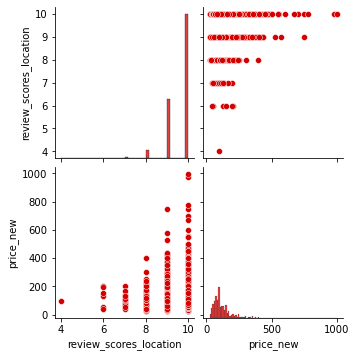

In [10]:
sns.pairplot(df_option1[['review_scores_location', 'price_new']]);
# Plot shows clear relationship with review score location and price and worth exploring how to add location into the model.

In [11]:
# Use neighbourhood to predict review score - will normalise neighbourhood and lead to a good potential predictor for a model

# Roll-up and get stats by neighbourhood
df_listing_des = df_listing_clean[['review_scores_location', 'neighbourhood_group_cleansed']].groupby('neighbourhood_group_cleansed') \
.describe(include = 'all').sort_values(by=('review_scores_location', 'count'))[[('review_scores_location', 'mean')]]

# For simplicity use the mean score for each location. This isn't ideal for 'Other neighborhoods' or neighbourhoods with
## low volumes i.e. high std.

# Join the average review score by neighbourhood
df_avglocscore = df_listing_clean.merge(df_listing_des, on='neighbourhood_group_cleansed', how='left')
print(df_listing_clean.shape)
print(df_avglocscore.shape)

# Next create new column review_scores_location_imp to be the average if review_scores_location is missing.
df_avglocscore['review_scores_location_imp'] = df_avglocscore['review_scores_location'] 
df_avglocscore['review_scores_location_imp'].fillna(df_avglocscore[('review_scores_location', 'mean')], inplace=True)
# df_avglocscore.head()

# create option 3
df_option3_temp = df_avglocscore.drop(['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_rating'
                                        , 'review_scores_checkin', 'review_scores_communication' 
                                          , 'review_scores_location' , 'review_scores_value'
                                          , 'reviews_per_month', 'host_acceptance_rate_new' 
                                         , 'host_response_rate_new' , 'days_since_first_review' 
                                       , 'days_since_last_review', 'host_total_listings_count' 
                                       # used the below so no longer need them
                                       , 'neighbourhood_group_cleansed'
                                      , ('review_scores_location', 'mean')], axis=1  )

# Gave me a warning but I checked that shape is as expect and looked at the data
print(df_option3_temp.shape)
df_option3 = df_option3_temp.dropna()
print(df_option3.shape)
# As expected gives same volumes as option 2 with 1 extra column.

(3818, 60)
(3818, 61)
(3818, 47)
(3794, 47)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


## Correlations
This prints out a massive heatmap - will need to zoom in. Observations:

* Clearly dummy variables are correlated
* host_listings_count 100% correlated with host_total_listings_count so can remove one. Went back and added above.
* Can see from this accommodates, bathrooms, bedrooms, beds, guests_included - correlated to price but also each other.
* Availability_... highly correlated to one another but not really with price.
* An earlier version showed me some of the _nan dummy variables were not populated so I went back and removed.


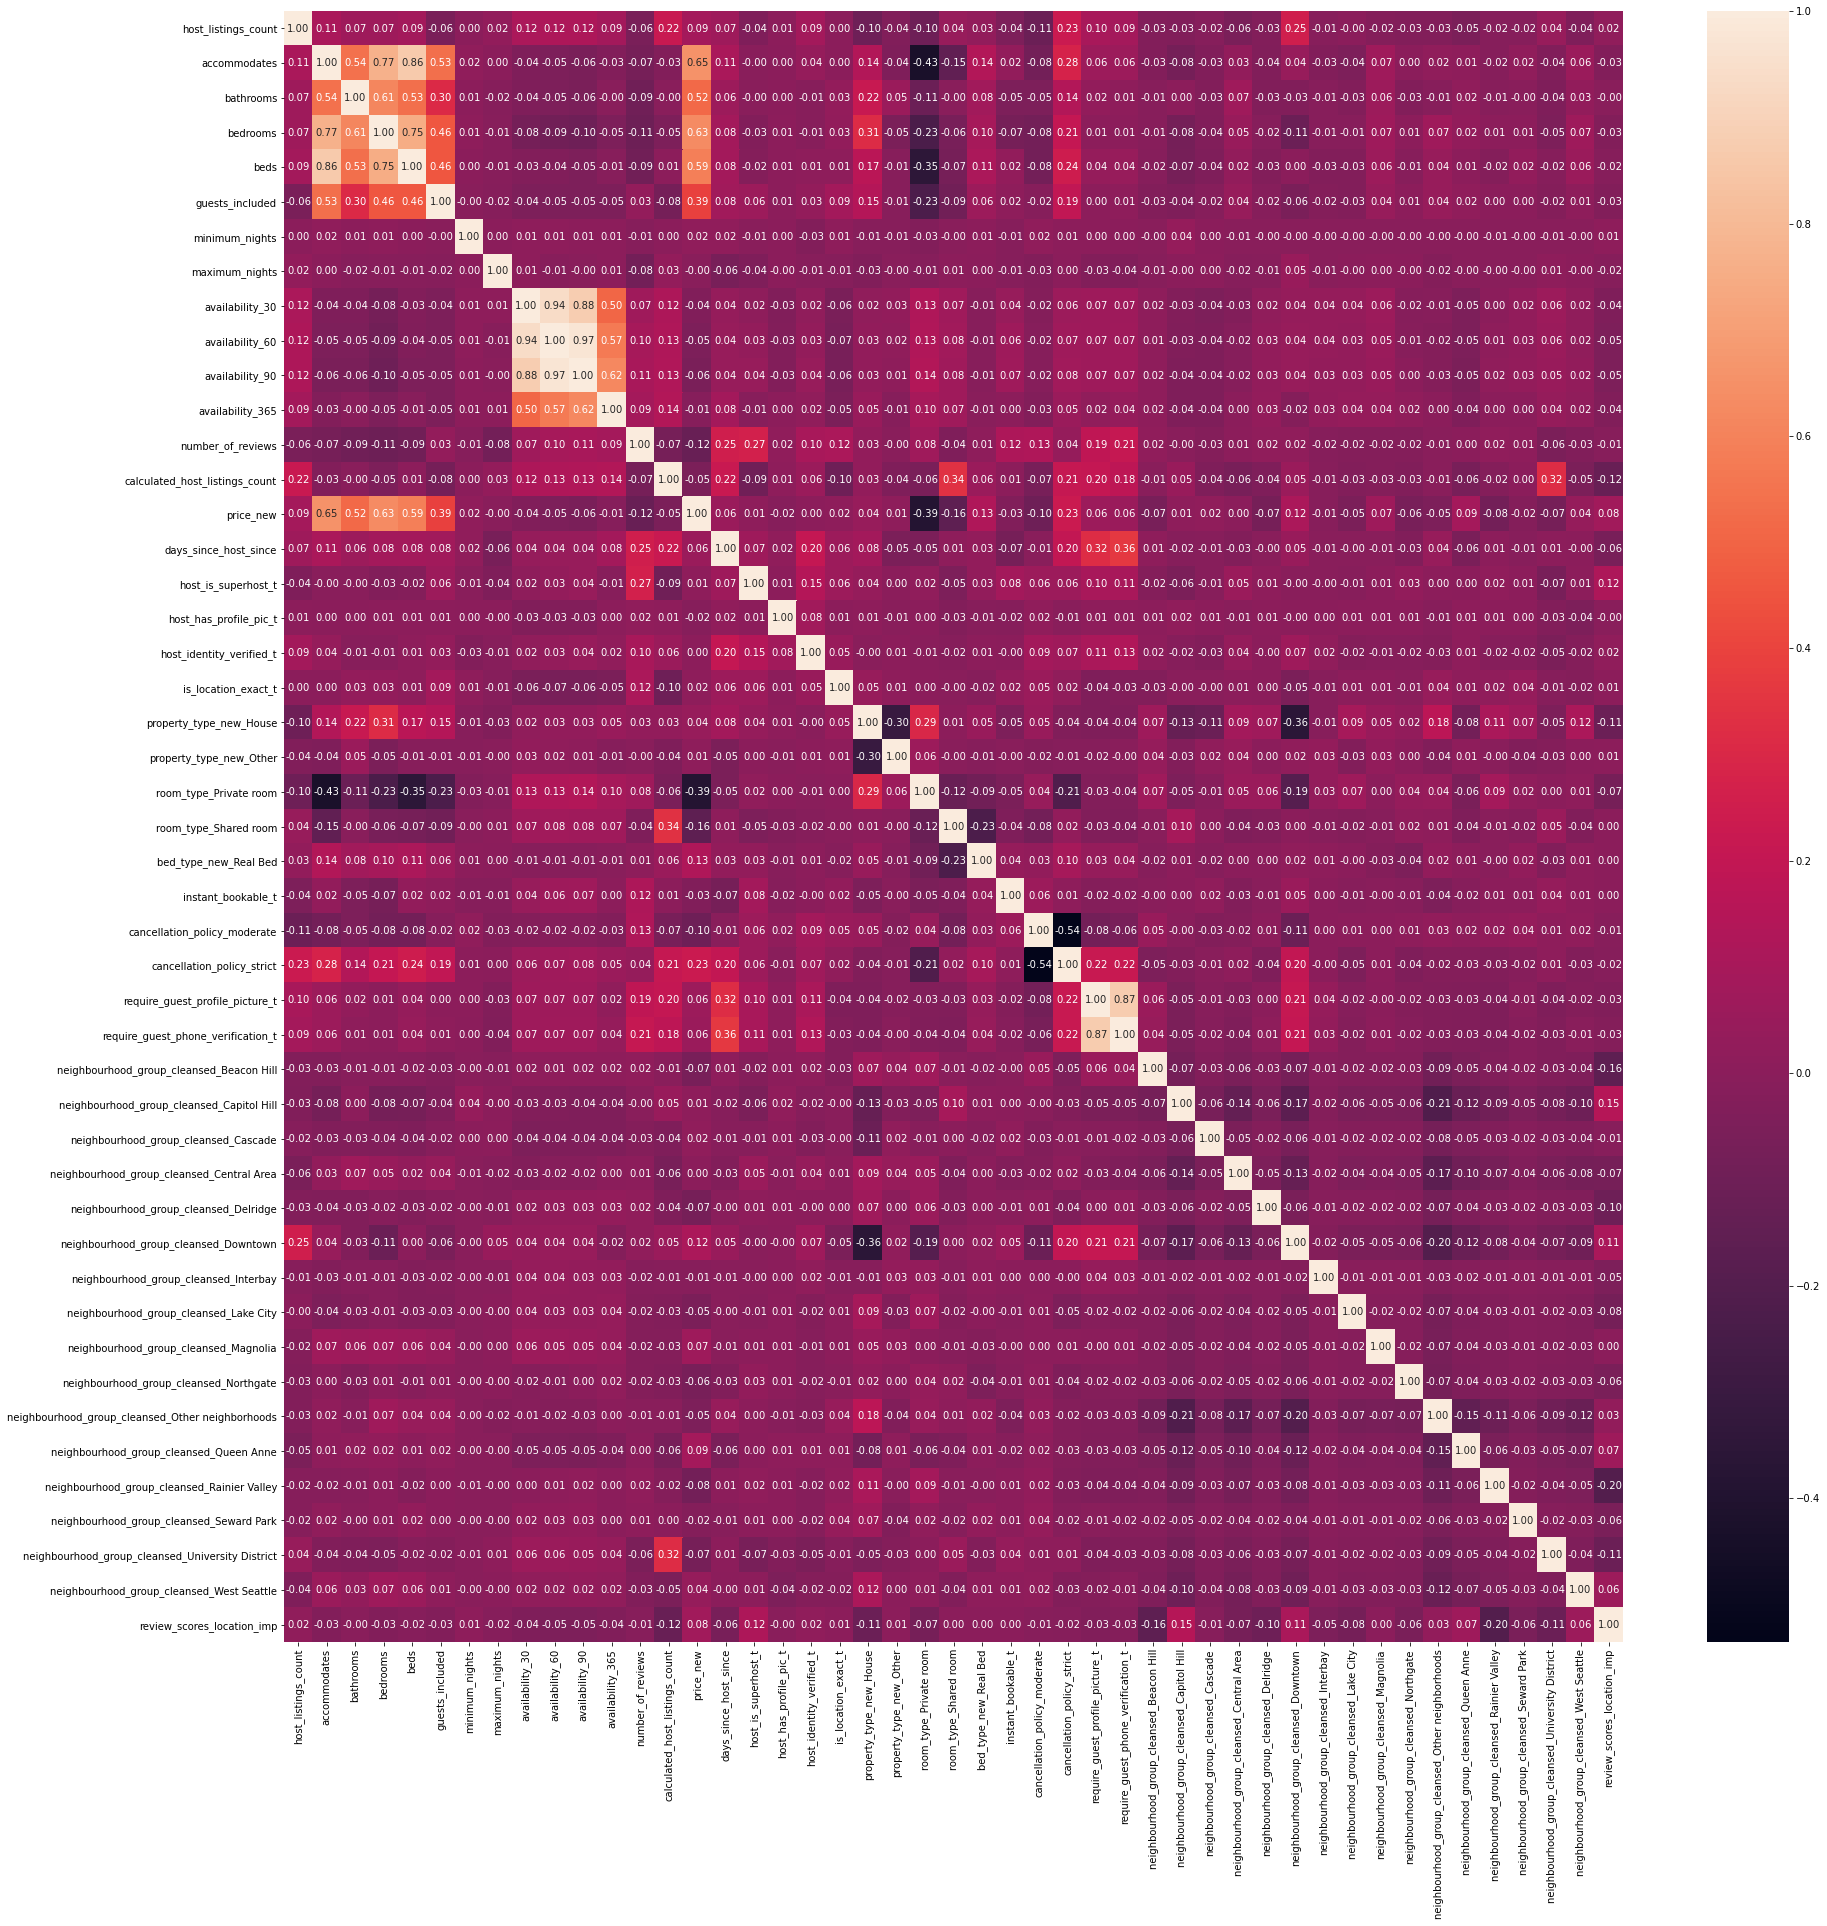

In [12]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_option3.corr(), annot=True, fmt='.2f');

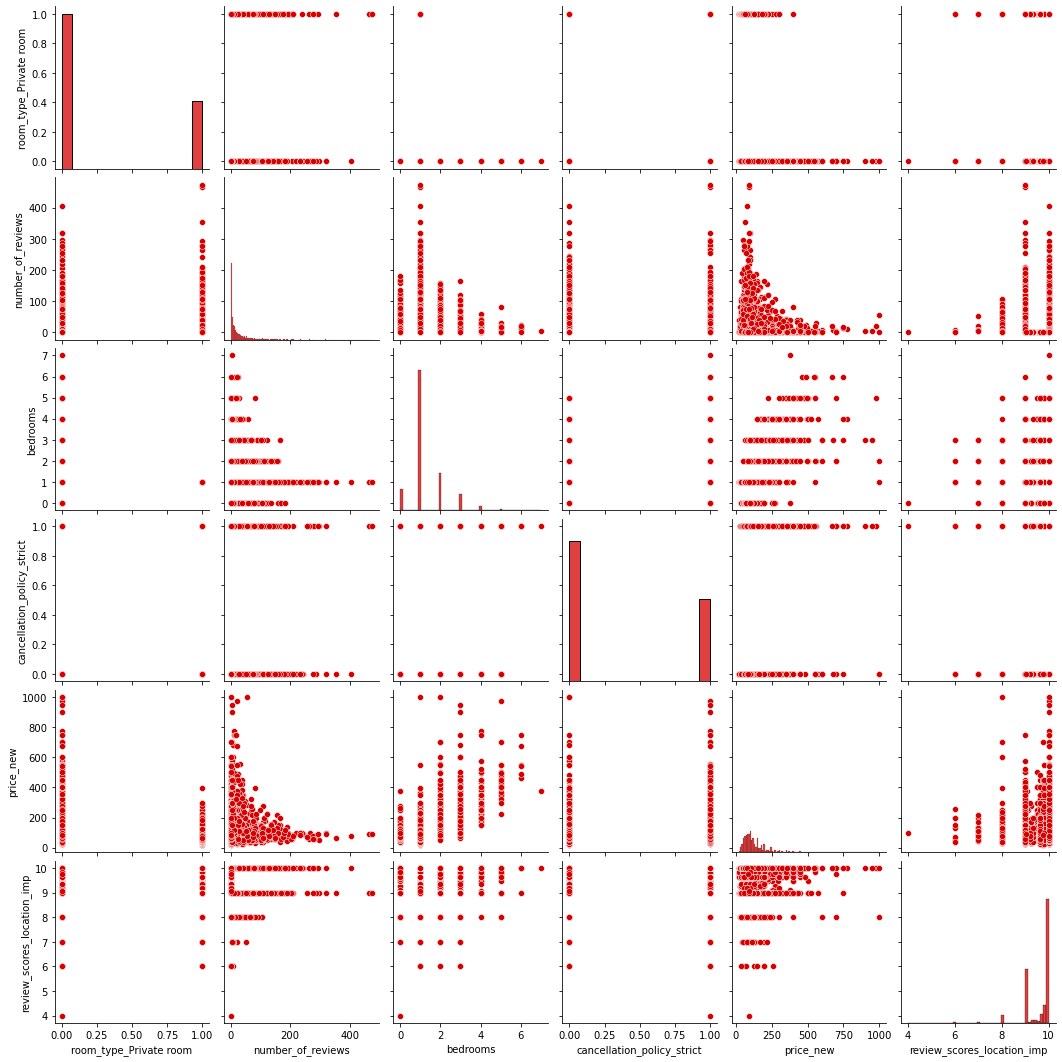

In [13]:
# Look at a pairplot of a few interesting variables
sns.pairplot(df_option3[['room_type_Private room', 'number_of_reviews', 'bedrooms', 'cancellation_policy_strict', 'price_new', 'review_scores_location_imp']]);

In [14]:
# Correlation to price
df_option3.corr().filter(items = ['price_new'], axis=1).sort_values(by='price_new')

,price_new
room_type_Private room,-0.388364
room_type_Shared room,-0.158765
number_of_reviews,-0.123519
cancellation_policy_moderate,-0.100761
neighbourhood_group_cleansed_Rainier Valley,-0.083464
neighbourhood_group_cleansed_Delridge,-0.072158
neighbourhood_group_cleansed_University District,-0.069306
neighbourhood_group_cleansed_Beacon Hill,-0.065461
neighbourhood_group_cleansed_Northgate,-0.061865
availability_90,-0.058191


# Modelling
A couple of models were built. 
1. A simple decision tree with 10 leafs
2. A linear regression model using rse to pick top 10 features
3. Ridge regression to pick top 10 features
4. Ridge regression to pick top X features by looping through and choosing the best X based on MSE.

## Set-up for model

In [15]:
# Pick features - not used in the end.
# X = df_option3[['room_type_Private room', 'host_listings_count', 'number_of_reviews', 'bedrooms', 'cancellation_policy_strict', 'review_scores_location_imp']] 
# feature_names = ['room_type_Private room', 'number_of_reviews', 'bedrooms', 'cancellation_policy_strict', 'review_scores_location_imp']

y = df_option3['price_new']

## Use all variables
feature_names_all = df_option3.columns.to_list()  
# Remove response - price_new
remove = ['price_new']
for i in remove:
    feature_names_all.remove(i)
X_all = df_option3[feature_names_all]

In [16]:
#Split into train and test
X_all_train, X_all_test, y_train, y_test = train_test_split(X_all, y, test_size = .30, random_state=42) 

## Model 1: Decision Tree
Using all features. Using default parameters except max_leaf_nodes=10 so that I can visualise the results.

In [17]:
# Fit decision Tree
model1_tree = DecisionTreeRegressor(random_state=0,max_leaf_nodes=10 )
clf =model1_tree.fit(X_all_train, y_train)

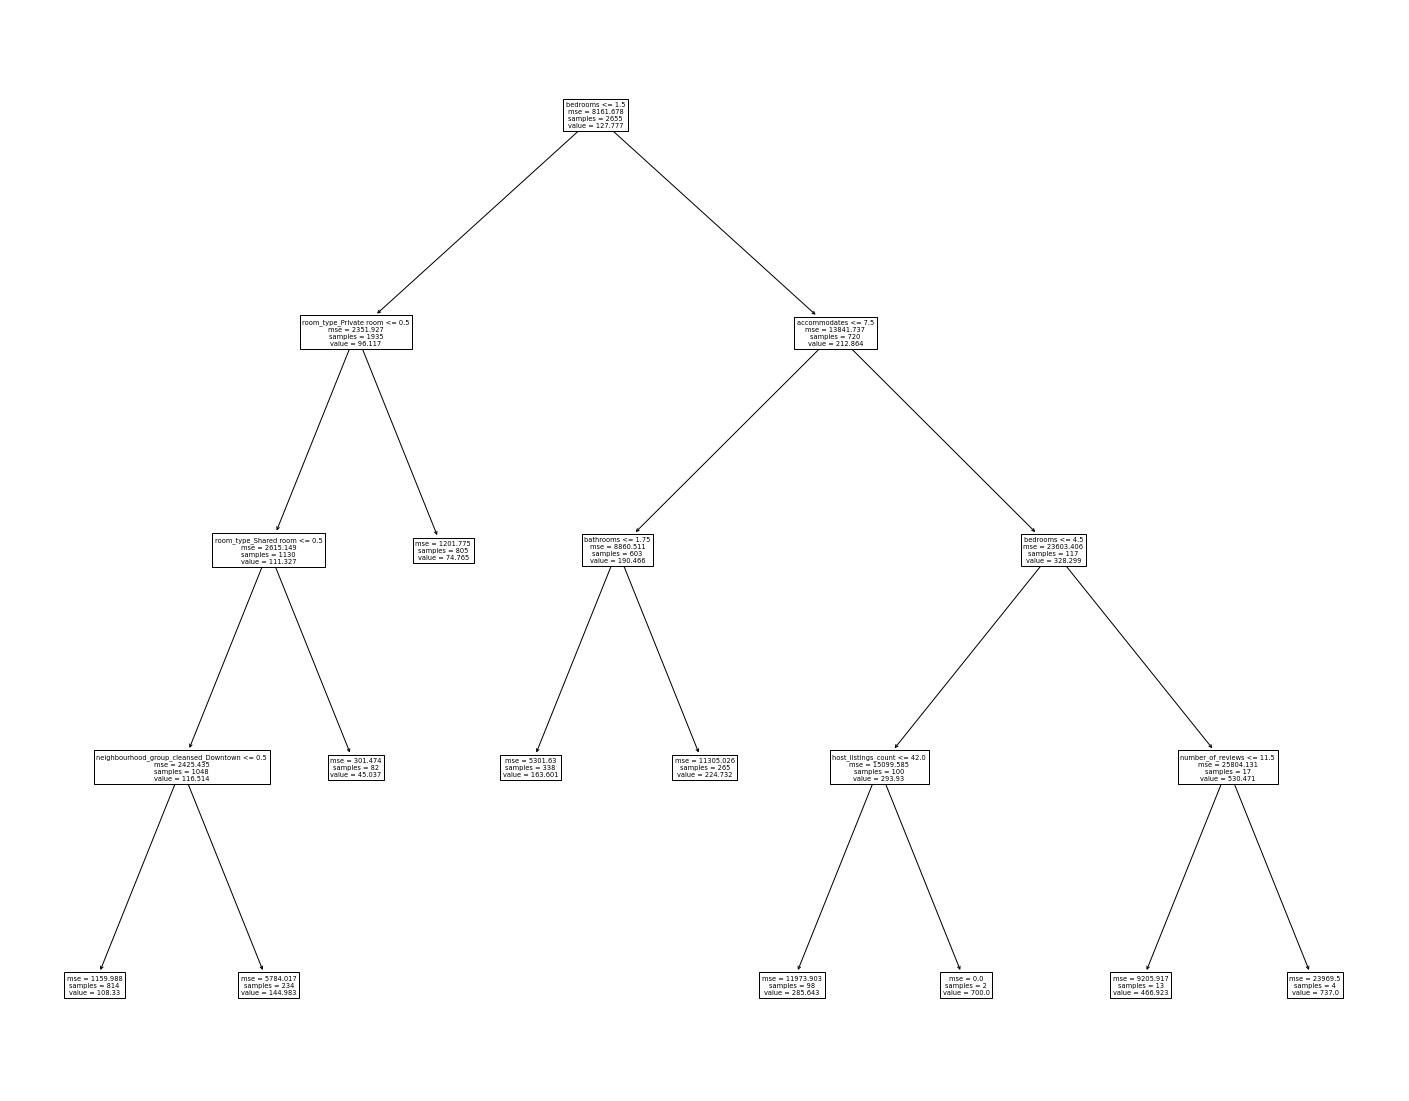

In [18]:
# Plot tree
fig = plt.figure(figsize=(25,20));
tree.plot_tree(clf, feature_names=feature_names_all);
plt.show();

Train
The MSE for your model was 59.71249394572508 on 2655 values.
The r-squared score for your model was 0.56313124423422 on 2655 values.
Test
The MSE for your model was 66.4156368762179 on 1139 values.
The r-squared score for your model was 0.4622526139001426 on 1139 values.


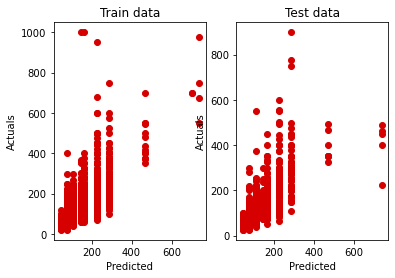

In [19]:
print_eval_reg(model1_tree)

## Model 2: Recursive feature eliminate - on Linear regression
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py

In [20]:
# Instantiate
lm_model = LinearRegression(normalize=True, fit_intercept=True) 

# Create the RFE object and rank each column
model2_rfe_lin = RFE(estimator=lm_model, n_features_to_select=10, step=1)
model2_rfe_lin.fit(X_all_train, y_train)

RFE(estimator=LinearRegression(normalize=True), n_features_to_select=10)

In [21]:
# summarize all features
f = model2_rfe_lin.get_support(1) #the most important features
X_top10 = X_all[X_all.columns[f]] # final features`
X_top10_cls = X_top10.columns.to_list()  
X_top10_cls

['bathrooms',
 'bedrooms',
 'host_has_profile_pic_t',
 'room_type_Private room',
 'room_type_Shared room',
 'neighbourhood_group_cleansed_Cascade',
 'neighbourhood_group_cleansed_Downtown',
 'neighbourhood_group_cleansed_Interbay',
 'neighbourhood_group_cleansed_Magnolia',
 'neighbourhood_group_cleansed_Queen Anne']

Train
The MSE for your model was 61.77207692800435 on 2655 values.
The r-squared score for your model was 0.5324748562482826 on 2655 values.
Test
The MSE for your model was 60.368510358617684 on 1139 values.
The r-squared score for your model was 0.5557181784983425 on 1139 values.


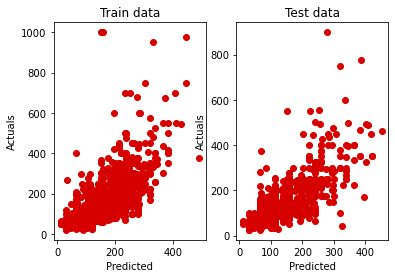

In [22]:
print_eval_reg(model2_rfe_lin)

## Model 3: Recursive feature eliminate - on Ridge regression

In [23]:
rr = Ridge(alpha=0.01)

# Create the RFE object and rank each pixel
# Using same model type as model 1(lm_model)
model3_rfe_rr = RFE(estimator=rr, n_features_to_select=10, step=1)
model3_rfe_rr.fit(X_all_train, y_train)

RFE(estimator=Ridge(alpha=0.01), n_features_to_select=10)

In [24]:
# summarize all features
f = model3_rfe_rr.get_support(1) #the most important features
X_top10 = X_all[X_all.columns[f]] # final features`
X_top10_cls = X_top10.columns.to_list()  
X_top10_cls

['bathrooms',
 'bedrooms',
 'host_has_profile_pic_t',
 'room_type_Private room',
 'room_type_Shared room',
 'neighbourhood_group_cleansed_Cascade',
 'neighbourhood_group_cleansed_Downtown',
 'neighbourhood_group_cleansed_Interbay',
 'neighbourhood_group_cleansed_Magnolia',
 'neighbourhood_group_cleansed_Queen Anne']

Train
The MSE for your model was 61.77207729848734 on 2655 values.
The r-squared score for your model was 0.5324748506402435 on 2655 values.
Test
The MSE for your model was 60.36860577529554 on 1139 values.
The r-squared score for your model was 0.5557167740598796 on 1139 values.


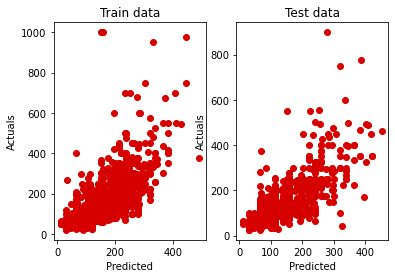

In [25]:
print_eval_reg(model3_rfe_rr)
# Hasn't made much difference with only 10 features

## Model 4: Hyper-paramter tuning to pick number of features

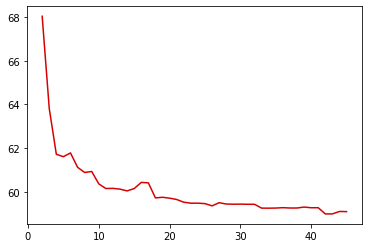

In [26]:
MSE_by_no_f = []
no_of_f = []

for i in range(1,len(feature_names_all)):
    rr = Ridge(alpha=0.01)
    model4_rfe_rrhp = RFE(estimator=rr, n_features_to_select=i, step=1)
    model4_rfe_rrhp.fit(X_all_train, y_train)
    
    #Predict and score the model
    y_test_preds = model4_rfe_rrhp.predict(X_all_test) 

    #Rsquared and y_test
    rsquared_scoretest = r2_score(y_test, y_test_preds)
    length_y_test = len(y_test)

    #  MSE
    mse_calctest = np.sqrt(mean_squared_error(y_test,y_test_preds))
    
#     print('Number of features = ', i, 'MSE is', mse_calctest)
    
    # Set-up lists
    MSE_by_no_f.append(mse_calctest)
    no_of_f.append(i)
    
plt.plot(no_of_f[1:], MSE_by_no_f[1:])

# Tails off around 20 but pick just before the peak at 15.

In [27]:
# Build based on 20 features
rr = Ridge(alpha=0.01)

# Create the RFE object and rank each pixel
# Using same model type as model 1(lm_model)
model4_rfe_rrhp = RFE(estimator=rr, n_features_to_select=14, step=1)
model4_rfe_rrhp.fit(X_all_train, y_train)

RFE(estimator=Ridge(alpha=0.01), n_features_to_select=14)

In [28]:
# summarize all features
f = model4_rfe_rrhp.get_support(1) #the most important features
X_top10 = X_all[X_all.columns[f]] # final features`
X_top10_cls = X_top10.columns.to_list()  
X_top10_cls

['bathrooms',
 'bedrooms',
 'host_has_profile_pic_t',
 'room_type_Private room',
 'room_type_Shared room',
 'neighbourhood_group_cleansed_Capitol Hill',
 'neighbourhood_group_cleansed_Cascade',
 'neighbourhood_group_cleansed_Delridge',
 'neighbourhood_group_cleansed_Downtown',
 'neighbourhood_group_cleansed_Interbay',
 'neighbourhood_group_cleansed_Magnolia',
 'neighbourhood_group_cleansed_Northgate',
 'neighbourhood_group_cleansed_Queen Anne',
 'neighbourhood_group_cleansed_Rainier Valley']

Train
The MSE for your model was 60.80388549297504 on 2655 values.
The r-squared score for your model was 0.5470156164858674 on 2655 values.
Test
The MSE for your model was 60.04751826053816 on 1139 values.
The r-squared score for your model was 0.5604302976784146 on 1139 values.


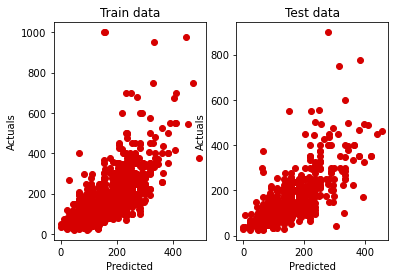

In [29]:
print_eval_reg(model4_rfe_rrhp)

## Make a prediction for the blog

In [30]:
# choose row at random to maintain the shape of the dataset
Xnew = X_all_test[(X_all_test['room_type_Private room'] == 1)  & (X_all_test['neighbourhood_group_cleansed_Downtown'] == 1)].iloc[[2]]
# Look at the variables that feed into the final model
Xnew[X_top10_cls]

,bathrooms,bedrooms,host_has_profile_pic_t,room_type_Private room,room_type_Shared room,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley
1443,1.0,1.0,1,1,0,0,0,0,1,0,0,0,0,0


In [31]:
# prediction
ynew = model4_rfe_rrhp.predict(Xnew)
ynew

array([107.33083537])